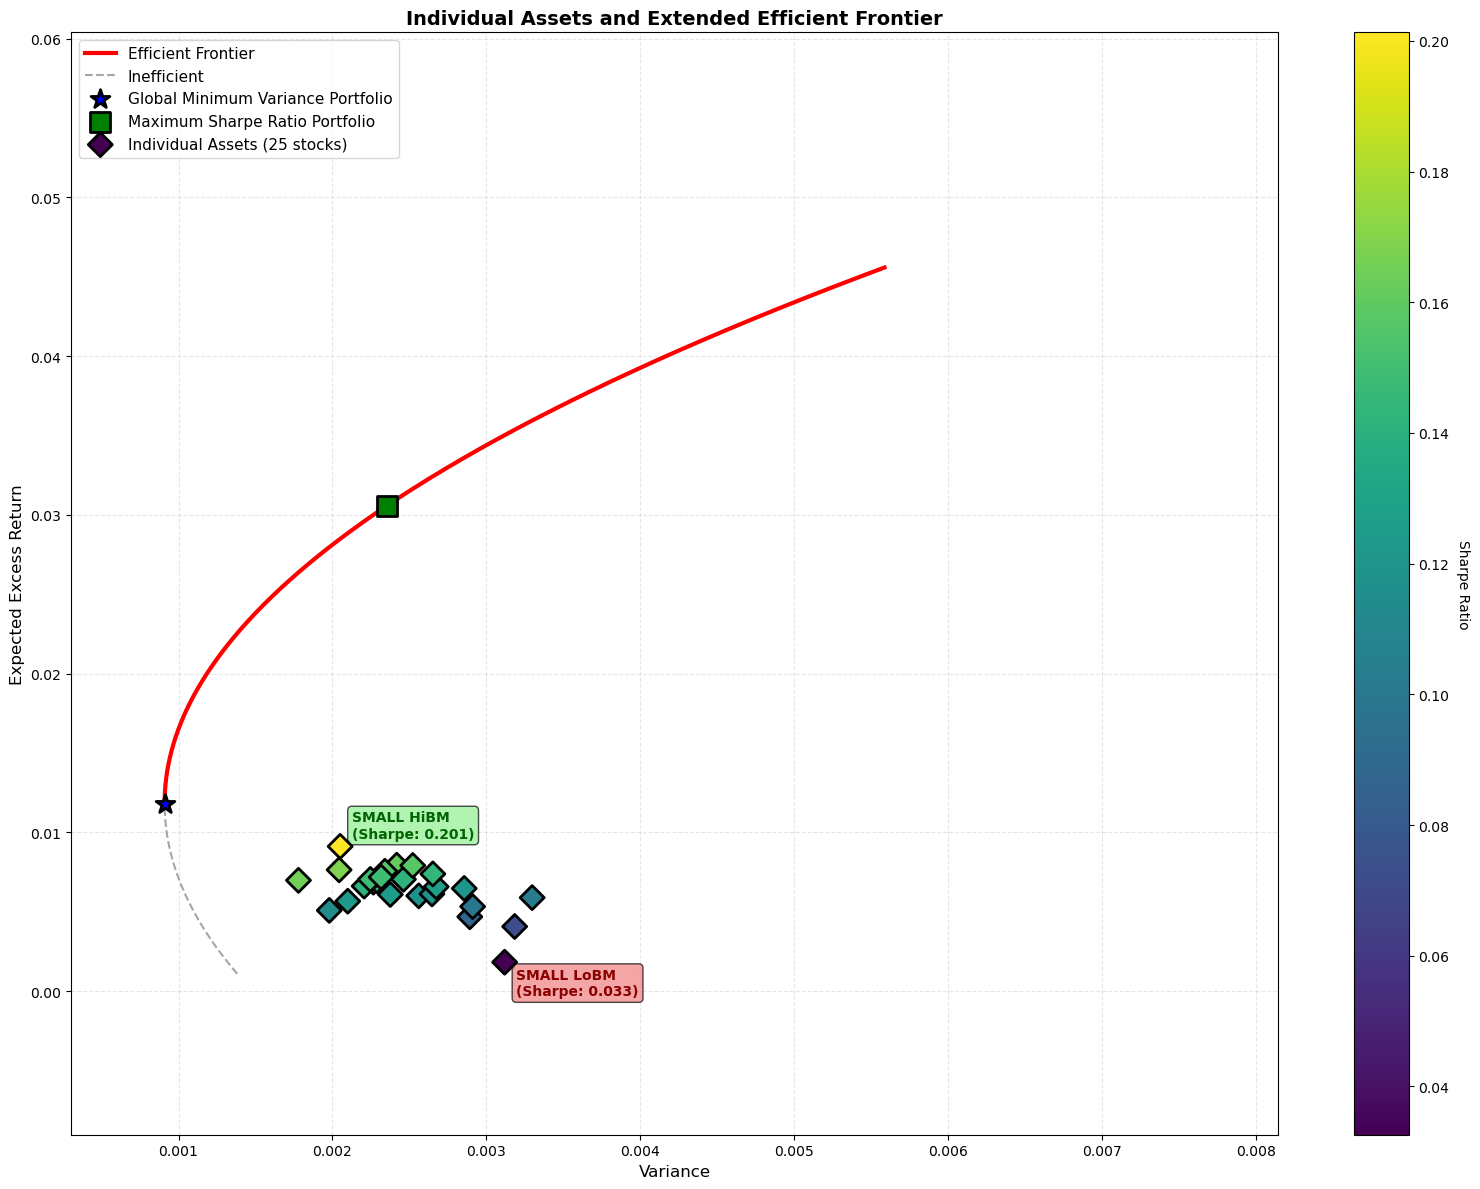

In [ ]:
# This code requires the files; Data and Monthly Tbill to run
# This code requires reading in the tbill and data separtely in this way as it was an earlier task done shortly after the very first task of creating the tangency portfolio
# Later notebooks will use a single raw data file for ease that has different sheet names and so will not run with that data.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(12345)

tbill = pd.read_excel(
    r"C:/Users/benre/OneDrive/Documents/University Of Warwick/Mathematical Finance MSc/Asset Pricing and Risk/Group Assignment/Report Final/Data/Monthly Tbill.xlsx",
    sheet_name="Tbill",
    header=0
)

annualyd = tbill.iloc[:, 1].to_numpy(dtype=float)
monthtbill = (1 + annualyd / 100) ** (1/12) - 1

assetsorig = pd.read_excel(
    r"C:/Users/benre/OneDrive/Documents/University Of Warwick/Mathematical Finance MSc/Asset Pricing and Risk/Group Assignment/Report Final/Data/Data.xlsx",
    sheet_name="Data",
    header=0
)

assetrets = assetsorig.iloc[:, 1:].to_numpy(dtype=float) / 100
excessrets = assetrets - monthtbill.reshape(-1, 1)
T = excessrets.shape[0]
expectedexrets = excessrets.sum(axis=0) / T
expectedexrets = expectedexrets.reshape(-1, 1)
covmat = np.cov(assetrets, rowvar=False, ddof=1)   # shape (25, 25)
indivvars = np.diag(covmat)
mu = expectedexrets.flatten()
indivvol = np.sqrt(indivvars)
assetSR = mu / indivvol

n_assets = 25
ones = np.ones(n_assets)
siginv = np.linalg.inv(covmat)
A = ones @ siginv @ ones        # 1'*Σ^-1*1
B = ones @ siginv @ mu          # 1'*Σ^-1*μ
C = mu @ siginv @ mu            # μ'*Σ^-1*μ
D = A * C - B * B

globalmvar = B / A
assetretmin = mu.min()
assetretmax = mu.max()
startret = min(globalmvar * 0.6, assetretmin * 0.6)  
endret = assetretmax * 5.0 
targetrets = np.linspace(startret, endret, 25000)
frontvars = []
frontrets = []

for r in targetrets:
    lambda1 = (C - B * r) / D
    lambda2 = (A * r - B) / D
    w = lambda1 * (siginv @ ones) + lambda2 * (siginv @ mu)
    portvar = w.T @ covmat @ w
    portret = w @ mu
    frontvars.append(portvar)
    frontrets.append(portret)

frontvars = np.array(frontvars)
frontrets = np.array(frontrets)
gmv_idx = np.argmin(frontvars)
gmv_return = frontrets[gmv_idx]
gmv_variance = frontvars[gmv_idx]
max_sharpe_weights = siginv @ mu
max_sharpe_weights = max_sharpe_weights / np.sum(max_sharpe_weights)
max_sharpe_return = max_sharpe_weights @ mu
max_sharpe_variance = max_sharpe_weights @ covmat @ max_sharpe_weights
max_sharpe_ratio = max_sharpe_return / np.sqrt(max_sharpe_variance)
min_sharpe_idx = np.argmin(assetSR)
max_sharpe_idx = np.argmax(assetSR)
assetnames = assetsorig.columns[1:].tolist()

plt.figure(figsize=(16, 12))  # Make graph big enough to include the inefficient frontier
# We need the inefficient frontier as this will show us where our indiviadual assets (suboptimal) lie 
efficient_indices = frontrets >= globalmvar

# All below changes the visuals of the plot
plt.plot(frontvars[efficient_indices], frontrets[efficient_indices], 
         color="red", linewidth=3, label="Efficient Frontier")
inefficient_indices = frontrets < globalmvar
plt.plot(frontvars[inefficient_indices], frontrets[inefficient_indices], 
         color="gray", linewidth=1.5, linestyle="--", alpha=0.7, label="Inefficient")
plt.scatter(gmv_variance, gmv_return, color='blue', s=200, marker='*', 
           edgecolors='black', linewidth=2, zorder=20, label='Global Minimum Variance Portfolio')
plt.scatter(max_sharpe_variance, max_sharpe_return, color='green', s=200, marker='s', 
           edgecolors='black', linewidth=2, zorder=20, label='Maximum Sharpe Ratio Portfolio')

# Now we can plot he original assets after extending the plot
scatter = plt.scatter(
    indivvars,
    mu,
    c=assetSR,
    cmap='viridis',
    marker='D',
    s=150,
    edgecolors='black',
    linewidth=2,
    label="Individual Assets (25 stocks)",
    zorder=10
)

xrange = indivvars.max() - indivvars.min()
yrange = mu.max() - mu.min()

# Lable the asset (out of our original 25) with the highest Sharpe ratio
plt.annotate(f'{assetnames[max_sharpe_idx]}\n(Sharpe: {assetSR[max_sharpe_idx]:.3f})',
             xy=(indivvars[max_sharpe_idx], mu[max_sharpe_idx]),
             xytext=(indivvars[max_sharpe_idx] + 0.05 * xrange, 
                    mu[max_sharpe_idx] + 0.05 * yrange),
             arrowprops=dict(arrowstyle='->', color='darkgreen', lw=1.5, alpha=0.7),
             fontsize=10, fontweight='bold', color='darkgreen',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
             ha='left', va='bottom')

# Do the same but this time for the asset with the lowest Sharpe ratio
plt.annotate(f'{assetnames[min_sharpe_idx]}\n(Sharpe: {assetSR[min_sharpe_idx]:.3f})',
             xy=(indivvars[min_sharpe_idx], mu[min_sharpe_idx]),
             xytext=(indivvars[min_sharpe_idx] + 0.05 * xrange, 
                    mu[min_sharpe_idx] - 0.05 * yrange),
             arrowprops=dict(arrowstyle='->', color='darkred', lw=1.5, alpha=0.7),
             fontsize=10, fontweight='bold', color='darkred',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
             ha='left', va='top')

# Add to the visuals of the plot like a legend
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', rotation=270, labelpad=15)
all_variances = np.concatenate([indivvars, frontvars])
all_returns = np.concatenate([mu, frontrets])
target_max_return = np.percentile(frontrets[efficient_indices], 80)
idx = np.argmin(np.abs(frontrets - target_max_return))
target_max_variance = frontvars[idx]
var_min = max(0, indivvars.min() * 0.8)
var_max = max(indivvars.max(), target_max_variance) * 1.8
ret_min = min(mu.min(), frontrets.min()) * 0.8
ret_max = max(mu.max(), target_max_return) * 1.3
var_padding = (var_max - var_min) * 0.2 
ret_padding = (ret_max - ret_min) * 0.2  
plt.xlim(max(0, var_min - var_padding), var_max + var_padding)
plt.ylim(ret_min - ret_padding, ret_max + ret_padding)
plt.xlabel("Variance", fontsize=12)
plt.ylabel("Expected Excess Return", fontsize=12)
plt.title("Individual Assets and Extended Efficient Frontier", 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()